In [2]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
import matplotlib.pyplot as plt
import numpy as np
import os
from common.utils import (
    draw_chart,
    plot_vax_timeline,
    ChartDrawer,
    filter_by_date_range,
)

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

from typing import Any
import matplotlib.dates as mdates
from matplotlib.patches import Patch

plt.rcParams.update(
    {
        "font.size": 14,  # default text size
        "axes.titlesize": 16,  # chart titles
        "axes.labelsize": 14,  # x/y labels
        "xtick.labelsize": 12,  # x-axis tick labels
        "ytick.labelsize": 12,  # y-axis tick labels
        "legend.fontsize": 12,  # legend text
    }
)

In [ ]:
# CONSTANTS
POJISTOVNA = "ozp"
VAX_PERIOD_IN_DAYS = 30

In [4]:
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

In [17]:
# VARIABLES
vax_dates_map: dict[AgeCohort, dict[int, list[datetime]]] = defaultdict(dict)
max_vax_intensity_map: dict[AgeCohort, dict[int, datetime]] = defaultdict(dict)

novax_ppl_predpisy_map: dict[AgeCohort, dict[datetime, int]] = defaultdict(
    lambda: defaultdict(int)
)
novax_ppl_prvopredpisy_map: dict[AgeCohort, dict[datetime, int]] = defaultdict(
    lambda: defaultdict(int)
)
novax_ppl_prednison_equivs_map: dict[AgeCohort, dict[datetime, float]] = defaultdict(
    lambda: defaultdict(float)
)
novax_ppl_imunosupresivy_map: dict[AgeCohort, dict[datetime, int]] = defaultdict(
    lambda: defaultdict(int)
)


vax_ppl_prvopredpisy_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
vax_ppl_predpisy_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
vax_ppl_prednison_equivs_map = defaultdict(
    lambda: defaultdict(lambda: defaultdict(int))
)
vax_ppl_imunosupresivy_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

# === MAX VAXINATION DATES BY COHORT ===
for person in persons:
    if person.died_at or not person.vaccines:
        continue
    for vax in person.vaccines:
        if vax.dose_number not in vax_dates_map[vax.age_cohort]:
            vax_dates_map[vax.age_cohort][vax.dose_number] = []
        vax_dates_map[vax.age_cohort][vax.dose_number].append(vax.date)


for age_cohort_at_prescription, doses_map in vax_dates_map.items():
    for dose_number, dates in doses_map.items():
        if not dates:
            continue

        max_date, _ = max(Counter(dates).items(), key=lambda x: x[1])
        max_vax_intensity_map[age_cohort_at_prescription][dose_number] = max_date


# === NOVAX PEOPLE METRICS ===
for p in persons:
    if p.died_at:
        continue

    if not p.vaccines:
        if not p.prescriptions:
            continue

        last_prescription_date: datetime = datetime.min.date()
        for prescription in p.prescriptions:
            age_cohort_at_prescription = prescription.age_cohort_at_prescription
            if (
                prescription.lekova_forma == "Injekční suspenze"
                or prescription.lekova_forma == "Injekční/infuzní roztok"
            ):
                if abs((last_prescription_date - prescription.date).days) < 14:
                    continue
            last_prescription_date = prescription.date

            if prescription.prescription_type == PrescriptionType.IMUNOSUPRESSIVE:
                novax_ppl_imunosupresivy_map[age_cohort_at_prescription][
                    prescription.date
                ] += 1

            novax_ppl_predpisy_map[age_cohort_at_prescription][prescription.date] += 1

            novax_ppl_prednison_equivs_map[age_cohort_at_prescription][
                prescription.date
            ] += 1

        first_prescription_date = p.prescriptions[0].date
        age_cohort_at_1st_prescription = p.prescriptions[0].age_cohort_at_prescription
        novax_ppl_prvopredpisy_map[age_cohort_at_1st_prescription][
            first_prescription_date
        ] += 1

for p in persons:
    if p.died_at or not p.vaccines:
        continue

    for vax in p.vaccines:
        max_int_date = max_vax_intensity_map[vax.age_cohort][vax.dose_number]
        if abs((vax.date - max_int_date).days) > VAX_PERIOD_IN_DAYS:
            continue

        if not p.prescriptions:
            continue

        # === PRESCRIPTIONS ===
        last_prescription_date: datetime = datetime.min.date()
        for prescription in p.prescriptions:

            if (
                prescription.lekova_forma == "Injekční suspenze"
                or prescription.lekova_forma == "Injekční/infuzní roztok"
            ):
                if abs((last_prescription_date - prescription.date).days) < 14:
                    continue
            last_prescription_date = prescription.date

            if prescription.prescription_type == PrescriptionType.IMUNOSUPRESSIVE:
                vax_ppl_imunosupresivy_map[vax.age_cohort][vax.dose_number][
                    prescription.date
                ] += 1

            # === PRESCRIPTIONS COUNT ===
            vax_ppl_predpisy_map[vax.age_cohort][vax.dose_number][
                prescription.date
            ] += 1

            # === PREDNISON EQUIV ===
            if prescription.prednison_equiv is not None:
                vax_ppl_prednison_equivs_map[vax.age_cohort][vax.dose_number][
                    prescription.date
                ] += prescription.prednison_equiv

        # === FIRST PRESCRIPTIONS ===
        first_prescription = min(p.prescriptions, key=lambda x: x.date)

        vax_ppl_prvopredpisy_map[vax.age_cohort][vax.dose_number][
            first_prescription.date
        ] += 1

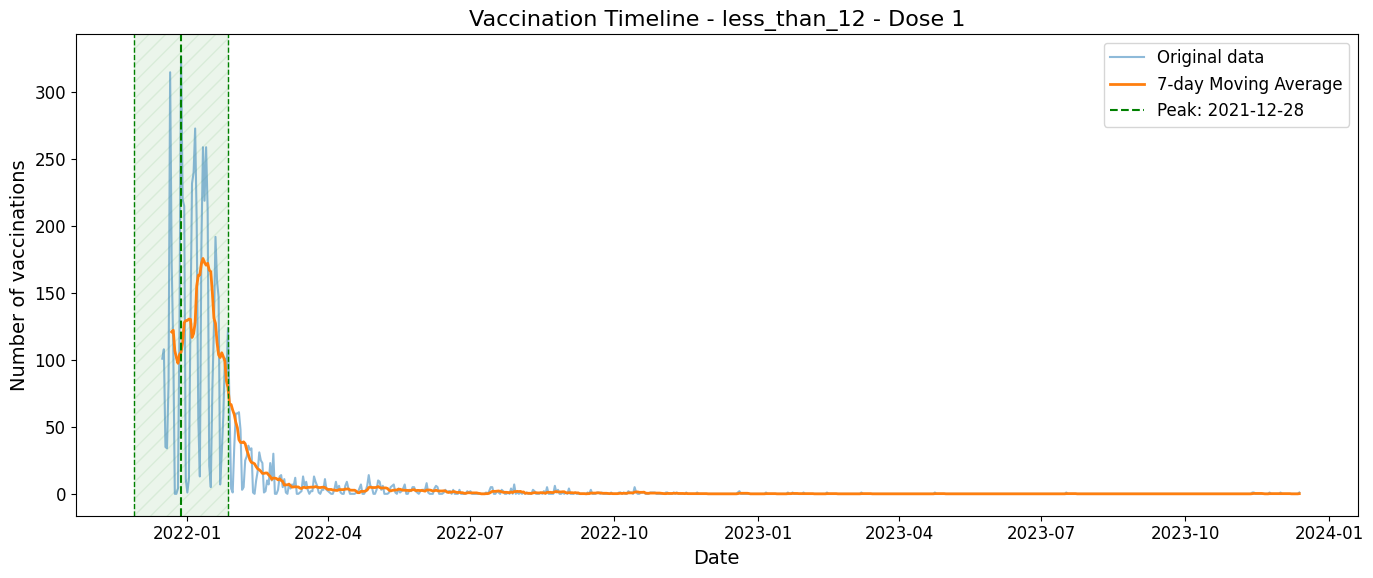

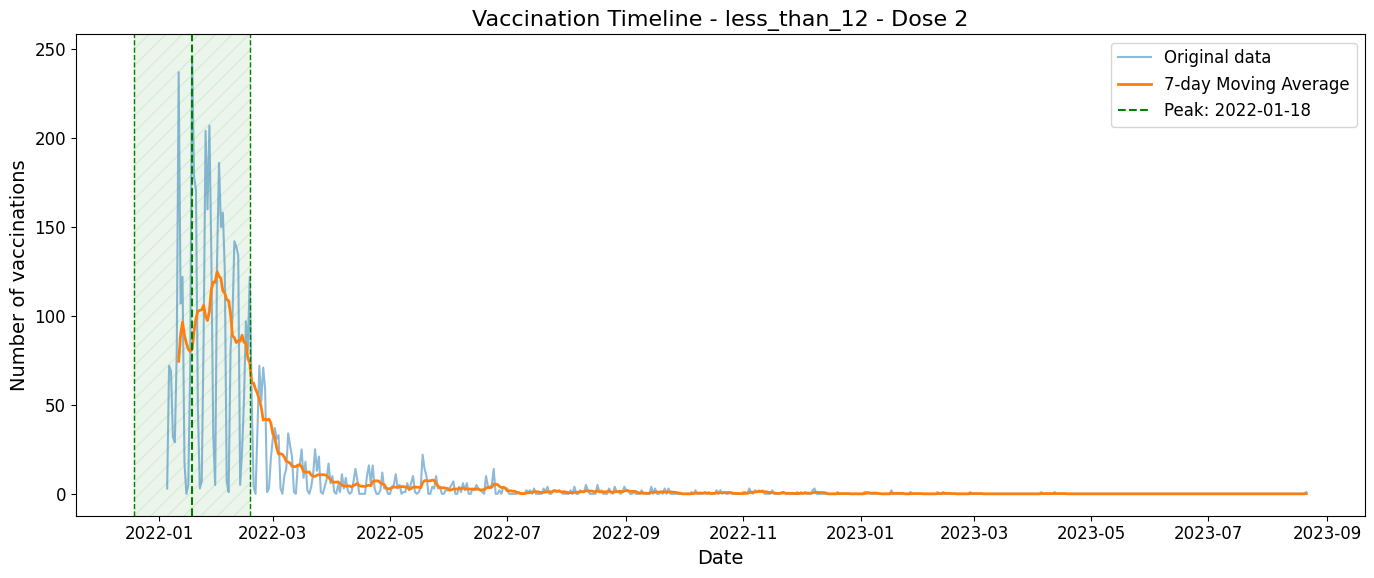

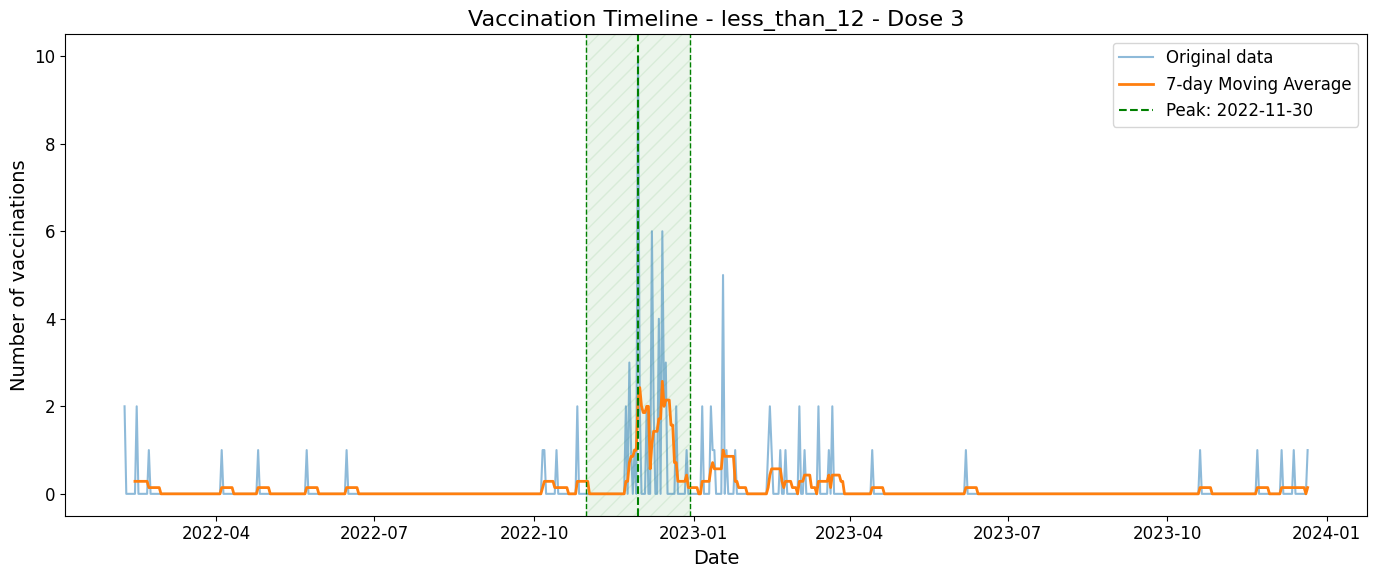

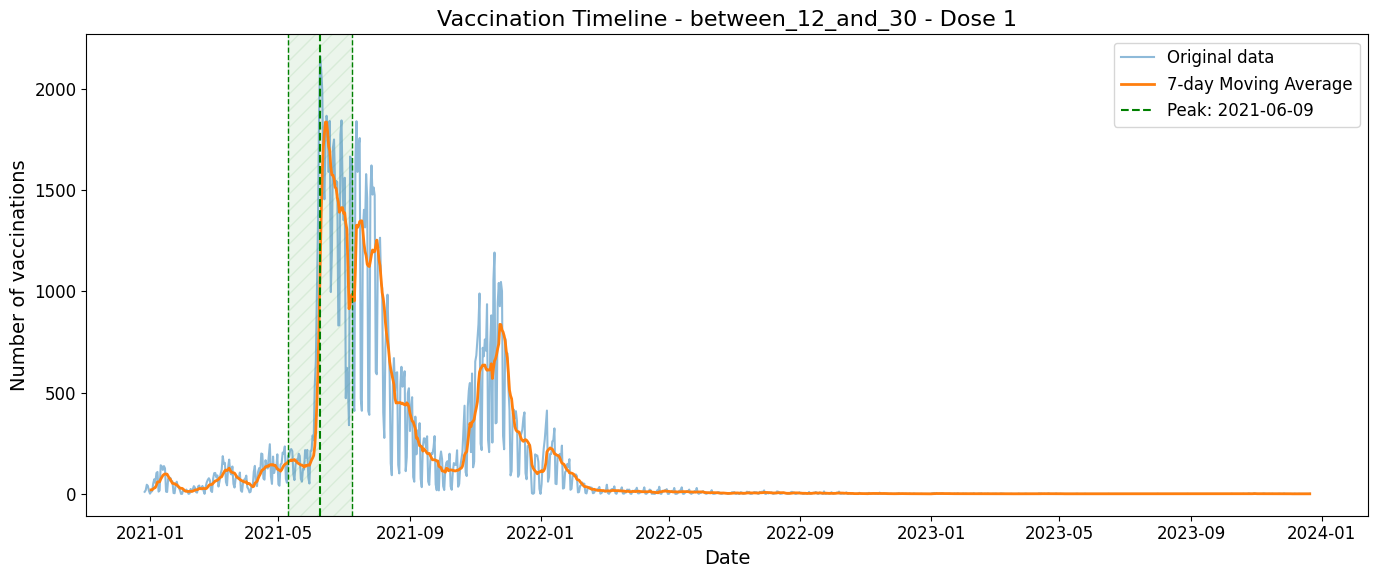

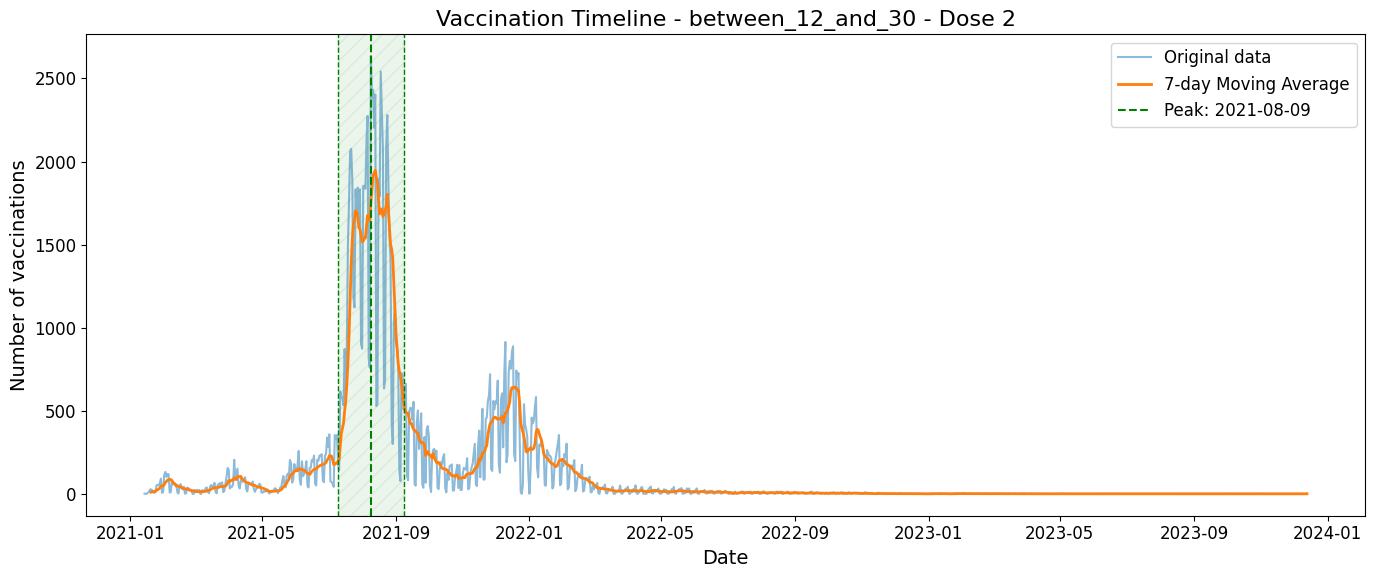

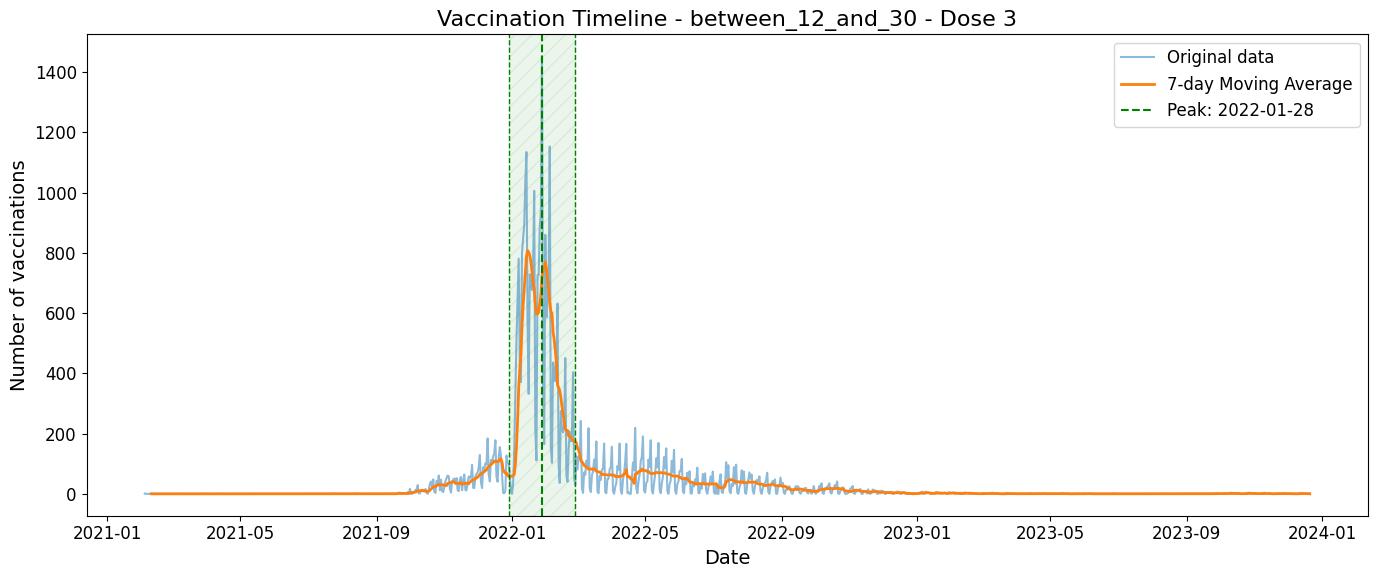

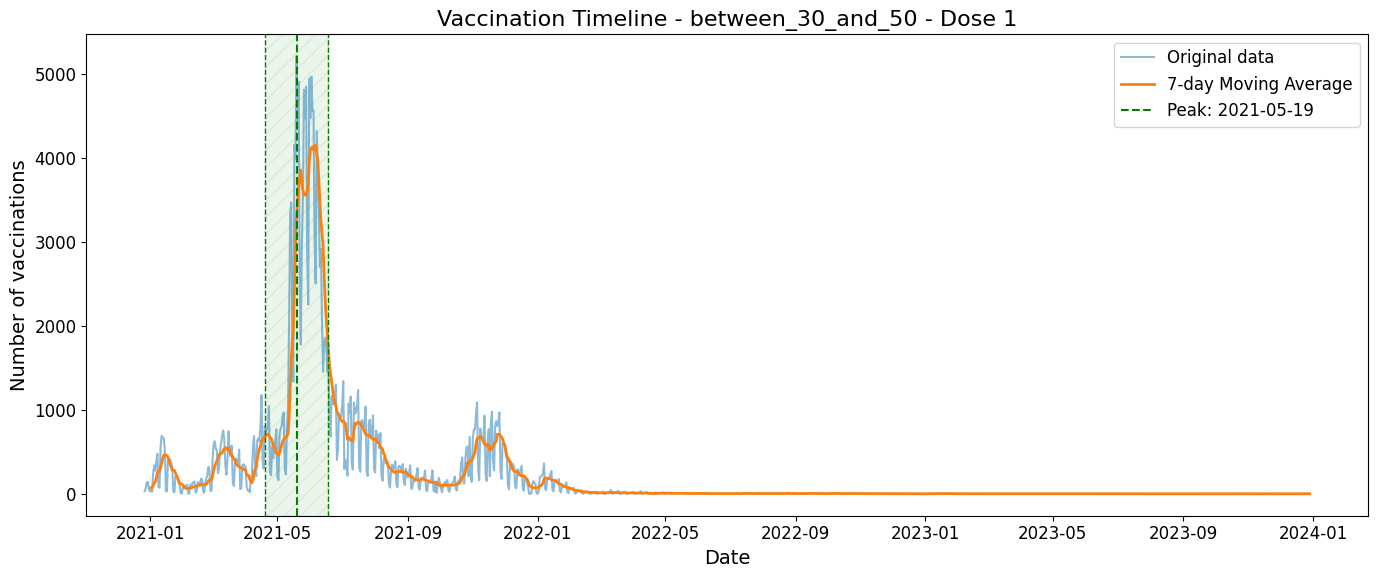

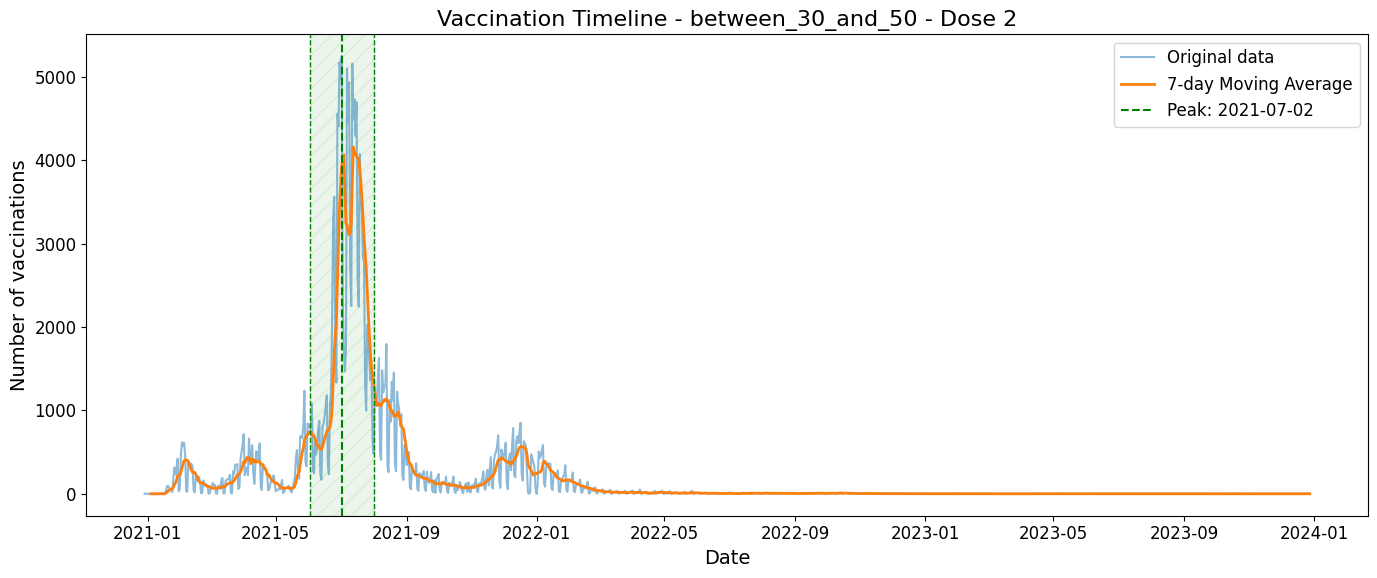

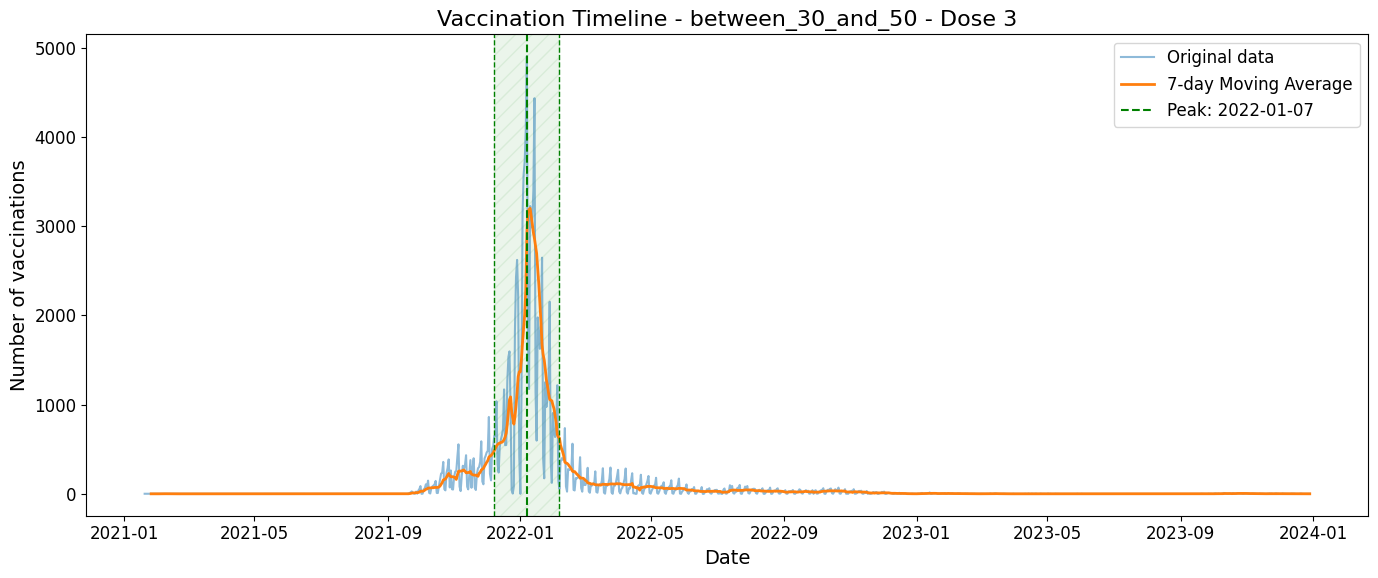

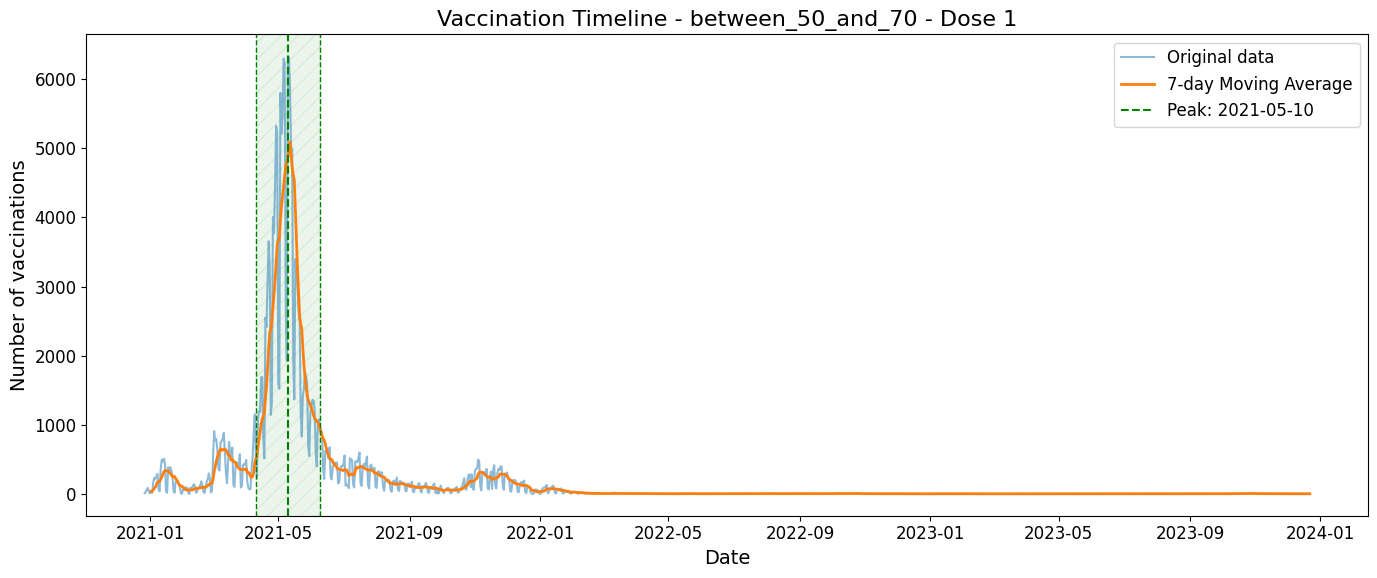

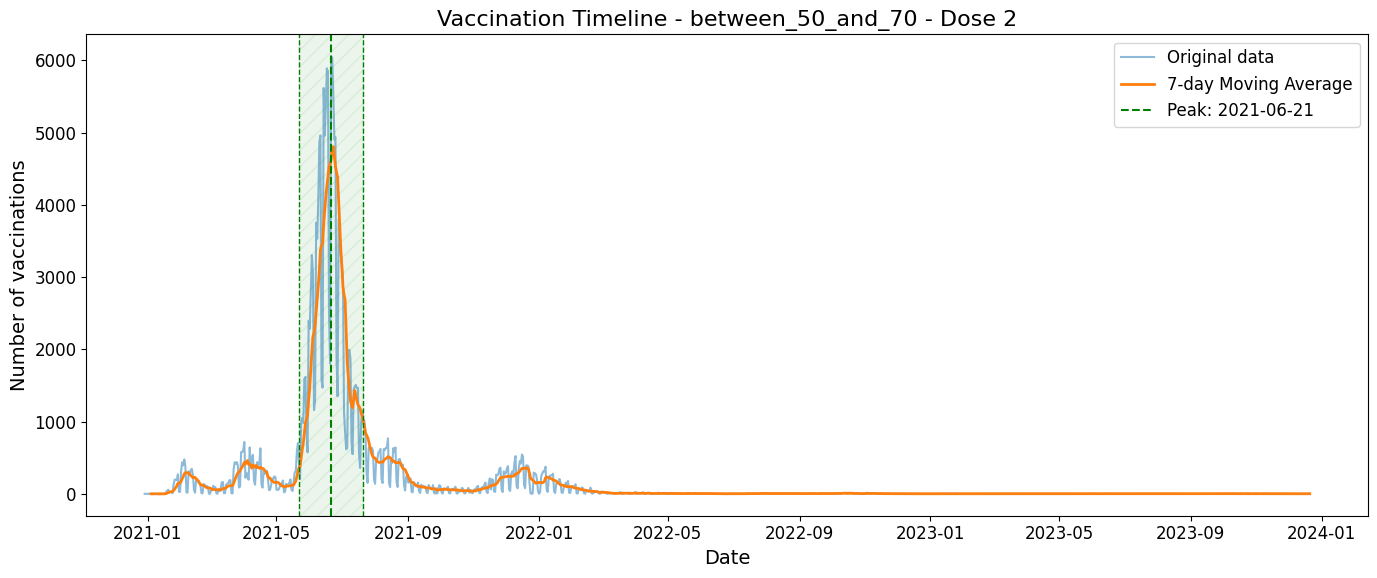

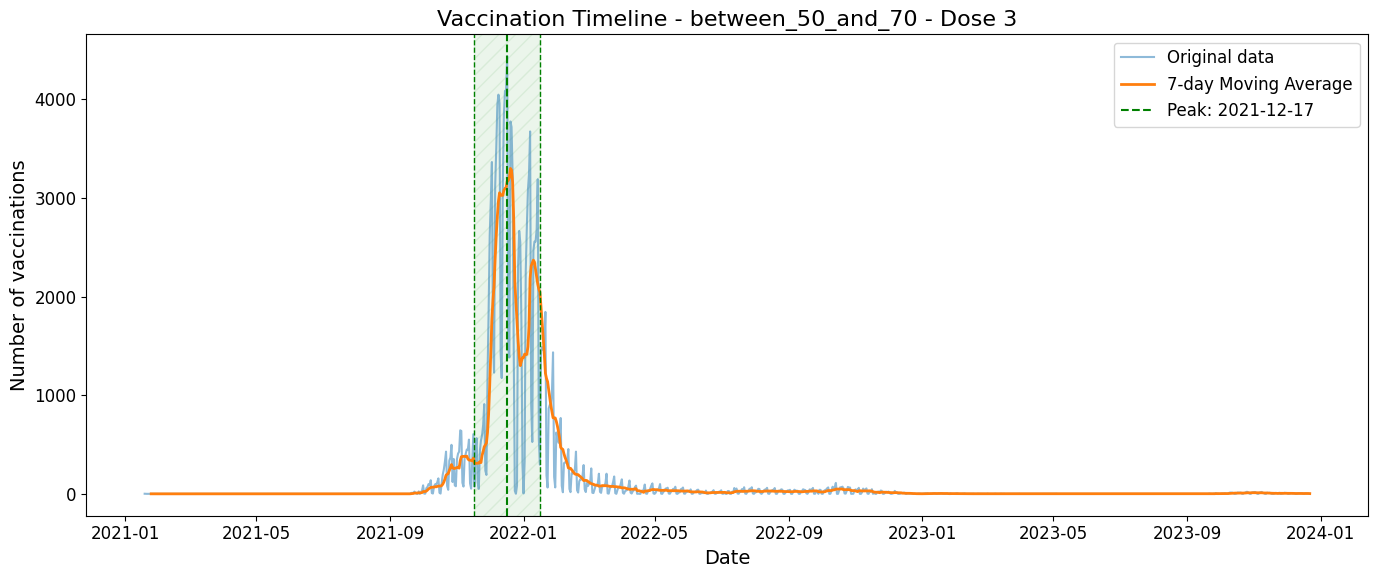

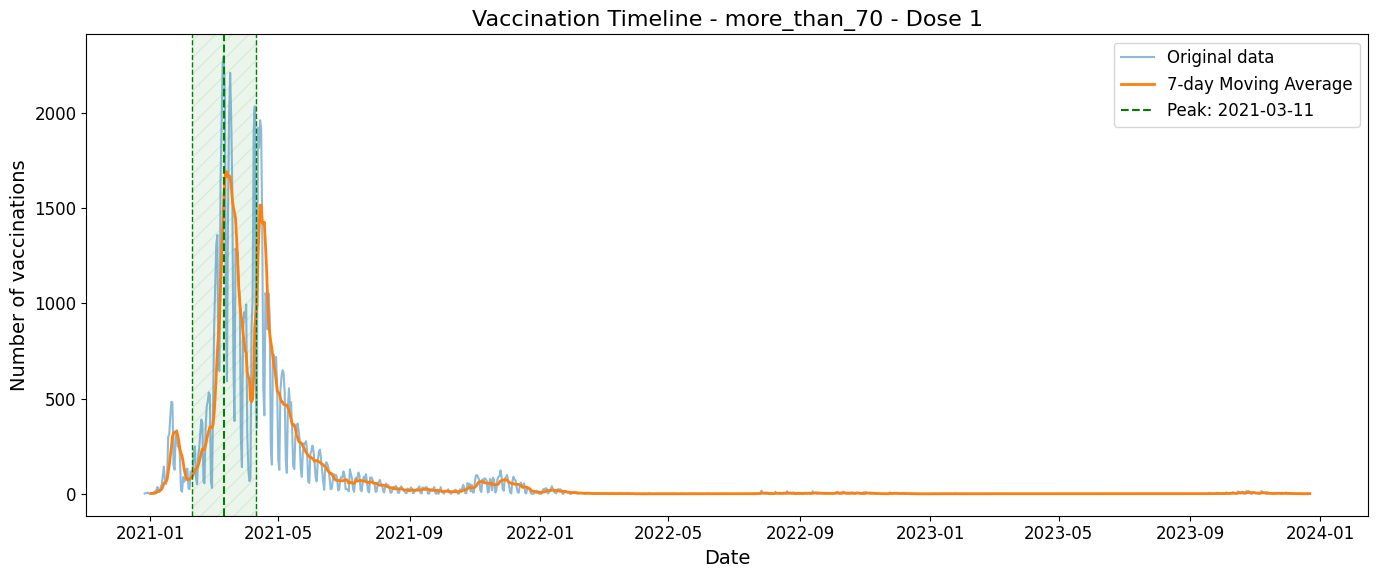

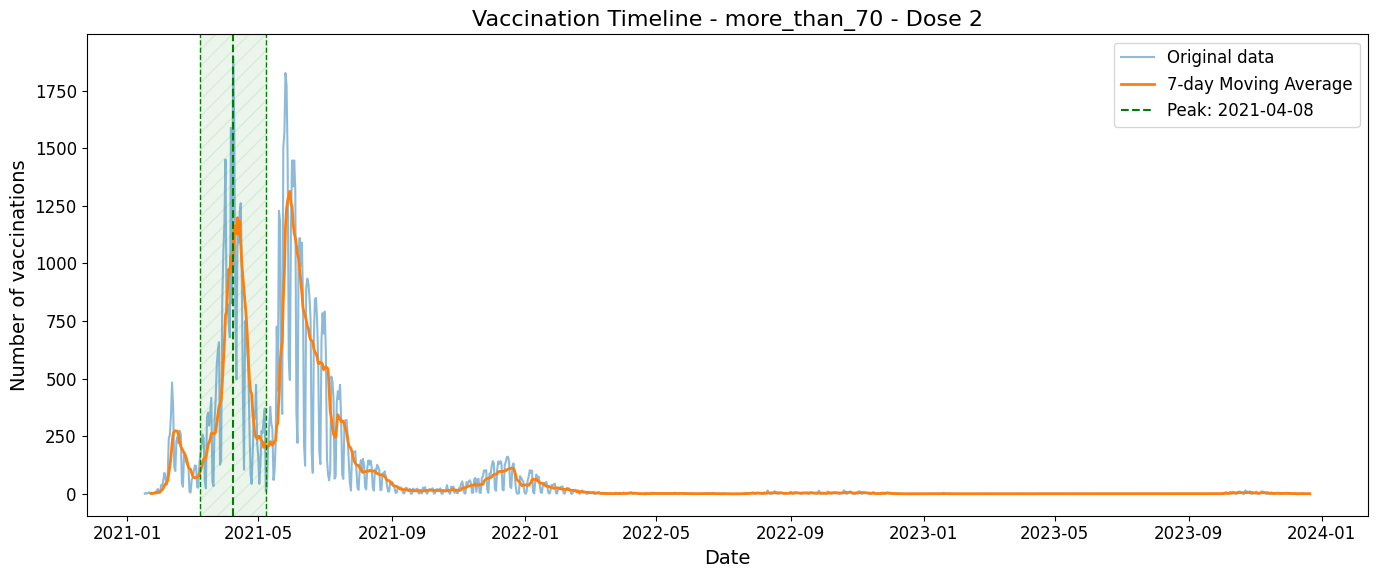

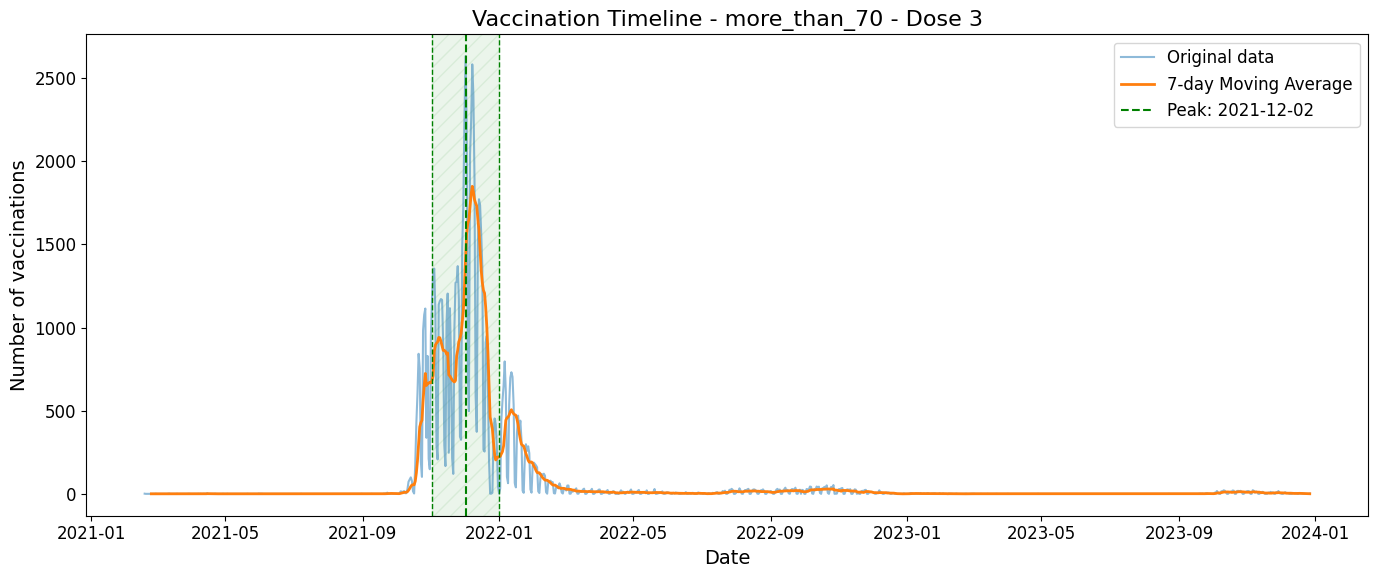

In [7]:
for age_cohort in AgeCohort:
    for dose_number in [1, 2, 3]:
        plot_vax_timeline(vax_dates_map, age_cohort, dose_number)

In [20]:
print(novax_ppl_predpisy_map)

defaultdict(<function <lambda> at 0x7f223b73cfe0>, {<AgeCohort.LESS_THAN_12: 'less_than_12'>: defaultdict(<class 'int'>, {datetime.date(2020, 9, 18): 28, datetime.date(2020, 9, 27): 3, datetime.date(2020, 10, 20): 20, datetime.date(2016, 4, 3): 2, datetime.date(2023, 11, 13): 70, datetime.date(2023, 1, 2): 61, datetime.date(2017, 9, 21): 21, datetime.date(2018, 1, 28): 7, datetime.date(2015, 3, 20): 39, datetime.date(2018, 3, 1): 32, datetime.date(2021, 8, 6): 25, datetime.date(2015, 12, 23): 45, datetime.date(2018, 5, 24): 13, datetime.date(2015, 9, 10): 29, datetime.date(2015, 10, 7): 29, datetime.date(2015, 10, 30): 48, datetime.date(2017, 10, 19): 38, datetime.date(2016, 7, 19): 12, datetime.date(2021, 11, 18): 61, datetime.date(2018, 4, 26): 21, datetime.date(2017, 10, 17): 16, datetime.date(2018, 2, 23): 22, datetime.date(2023, 2, 15): 34, datetime.date(2023, 11, 22): 62, datetime.date(2018, 12, 4): 24, datetime.date(2015, 12, 10): 45, datetime.date(2023, 7, 31): 14, datetime.dat

In [21]:
for PRESCRIPTION_PERIOD_IN_DAYS in [30, 60, 90, 180, 364]:
    for age_cohort_at_prescription in AgeCohort:
        for dose_number in [1, 2, 3]:
            rozhodne_datum = max_vax_intensity_map[age_cohort_at_prescription][
                dose_number
            ]

            def filter_current_vax_cohort(
                dates_map: dict[AgeCohort, dict[int, dict[datetime, int]]],
            ) -> dict[datetime, int]:
                return filter_by_date_range(
                    dates_map[age_cohort_at_prescription][dose_number],
                    rozhodne_datum,
                    PRESCRIPTION_PERIOD_IN_DAYS,
                )

            def filter_current_novax_cohort(
                dates_map: dict[AgeCohort, dict[datetime, int]],
            ) -> dict[datetime, int]:
                return filter_by_date_range(
                    dates_map[age_cohort_at_prescription],
                    rozhodne_datum,
                    PRESCRIPTION_PERIOD_IN_DAYS,
                )

            vax_predpisy_map = filter_current_vax_cohort(vax_ppl_predpisy_map)
            novax_predpisy_map = filter_current_novax_cohort(novax_ppl_predpisy_map)

            vax_prvopredpisy_map = filter_current_vax_cohort(vax_ppl_prvopredpisy_map)
            novax_prvopredpisy_map = filter_current_novax_cohort(
                novax_ppl_prvopredpisy_map
            )

            vax_kortikoidy_map = filter_current_vax_cohort(vax_ppl_prednison_equivs_map)
            novax_kortikoidy_map = filter_current_novax_cohort(
                novax_ppl_prednison_equivs_map
            )

            vax_imunosupresivy_map = filter_current_vax_cohort(
                vax_ppl_imunosupresivy_map
            )
            novax_imunosupresivy_map = filter_current_novax_cohort(
                novax_ppl_imunosupresivy_map
            )

            drawer = ChartDrawer()

            # fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(80, 20))
            # fig.tight_layout(pad=10.0)
            # fig.suptitle(
            #     f" {POJISTOVNA} - {PRESCRIPTION_PERIOD_IN_DAYS} Dnů od {rozhodne_datum.strftime('%d.%m.%Y')} - {age_cohort_at_prescription.value} - Dose {dose_number}",
            #     fontsize=36,
            # )

            # drawer = ChartDrawer()

            # drawer.draw_2x2_block(
            #     vax_dates_map=vax_predpisy_map,
            #     novax_dates_map=novax_predpisy_map,
            #     rozhodne_datum=rozhodne_datum,
            #     title="Předpisy",
            #     axes=axes,
            #     row_offset=0,
            #     col_offset=0,
            # )
            # drawer.draw_2x2_block(
            #     vax_dates_map=vax_prvopredpisy_map,
            #     novax_dates_map=novax_prvopredpisy_map,
            #     rozhodne_datum=rozhodne_datum,
            #     title="Prvopředpisy",
            #     axes=axes,
            #     row_offset=0,
            #     col_offset=2,
            # )
            # drawer.draw_2x2_block(
            #     vax_dates_map=vax_kortikoidy_map,
            #     novax_dates_map=novax_kortikoidy_map,
            #     rozhodne_datum=rozhodne_datum,
            #     title="Kortikoidové ekvivalenty",
            #     axes=axes,
            #     row_offset=0,
            #     col_offset=4,
            # )

            # drawer.draw_2x2_block(
            #     vax_dates_map=vax_imunosupresivy_map,
            #     novax_dates_map=novax_imunosupresivy_map,
            #     rozhodne_datum=rozhodne_datum,
            #     title="Imunosupresivní předpisy",
            #     axes=axes,
            #     row_offset=0,
            #     col_offset=6,
            # )
            fig, axes = plt.subplots(1, 4, figsize=(60, 10))  # 4 řádky, 1 sloupec
            fig.tight_layout(pad=10.0)
            fig.suptitle(
                f" {POJISTOVNA} - {PRESCRIPTION_PERIOD_IN_DAYS} Dnů od {rozhodne_datum.strftime('%d.%m.%Y')} - {age_cohort_at_prescription.value} - Dose {dose_number}",
                fontsize=46,
            )

            drawer.draw_vax_vs_unvax_sums(
                axes[0],
                vax_predpisy_map,
                novax_predpisy_map,
                rozhodne_datum,
                f"Součet předpisů před/po {PRESCRIPTION_PERIOD_IN_DAYS} dnů od {rozhodne_datum.strftime('%d.%m.%Y')} ve srovnání s neočkovanými",
            )
            drawer.draw_vax_vs_unvax_sums(
                axes[1],
                vax_prvopredpisy_map,
                novax_prvopredpisy_map,
                rozhodne_datum,
                f"Součet prvopředpisů před/po {PRESCRIPTION_PERIOD_IN_DAYS} dnů od {rozhodne_datum.strftime('%d.%m.%Y')} ve srovnání s neočkovanými",
            )
            drawer.draw_vax_vs_unvax_sums(
                axes[2],
                vax_kortikoidy_map,
                novax_kortikoidy_map,
                rozhodne_datum,
                f"Součet kortikoidových ekvivalentů před/po {PRESCRIPTION_PERIOD_IN_DAYS} dnů od {rozhodne_datum.strftime('%d.%m.%Y')} ve srovnání s neočkovanými",
            )
            drawer.draw_vax_vs_unvax_sums(
                axes[3],
                vax_imunosupresivy_map,
                novax_imunosupresivy_map,
                rozhodne_datum,
                f"Součet imunosupresivních předpisů před/po {PRESCRIPTION_PERIOD_IN_DAYS} dnů od {rozhodne_datum.strftime('%d.%m.%Y')} ve srovnání s neočkovanými",
            )
            os.makedirs(
                f"out/{POJISTOVNA}/sums/{PRESCRIPTION_PERIOD_IN_DAYS}", exist_ok=True
            )
            plt.savefig(
                f"out/{POJISTOVNA}/sums/{PRESCRIPTION_PERIOD_IN_DAYS}/{age_cohort_at_prescription.value}-{dose_number}.png"
            )
            plt.close(fig)